<a href="https://colab.research.google.com/github/brandonwagstaff/lidar_feature_matching/blob/main/optimal_transport/superglue_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Loading the image
img1 = cv2.imread('frame-000456.color.jpg')

 # Converting image to grayscale
gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

# Applying SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)

# Loading the image
img2 = cv2.imread('frame-000462.color.jpg')

 # Converting image to grayscale
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
kp2, des2 = sift.detectAndCompute(gray2, None)

x1 = []
y1 = []
for point in kp1:
  x1.append(point.pt[0])
  y1.append(point.pt[1])

x2 = []
y2 = []
for point in kp2:
  x2.append(point.pt[0])
  y2.append(point.pt[1])

X1 = np.array([x1, y1]).T
X2 = np.array([x2, y2]).T

n = X1.shape[0]
m = X2.shape[0]

Our optimal transport version:

In [1]:
def compute_optimal_transport(M, r, c, lam, epsilon=1e-5):
    """
    Computes the optimal transport matrix and Slinkhorn distance using the
    Sinkhorn-Knopp algorithm

    Inputs:
        - M : cost matrix (n x m)
        - r : vector of marginals (n, )
        - c : vector of marginals (m, )
        - lam : strength of the entropic regularization
        - epsilon : convergence parameter

    Output:
        - P : optimal transport matrix (n x m)
        - dist : Sinkhorn distance
    """
    n, m = M.shape
    P = np.exp(- lam * M)
    P /= P.sum()
    u = np.zeros(n)
    # normalize this matrix
    while np.max(np.abs(u - P.sum(1))) > epsilon:
        u = P.sum(1)
        P *= (r / u).reshape((-1, 1))
        P *= (c / P.sum(0)).reshape((1, -1))
    return P, np.sum(P * M)

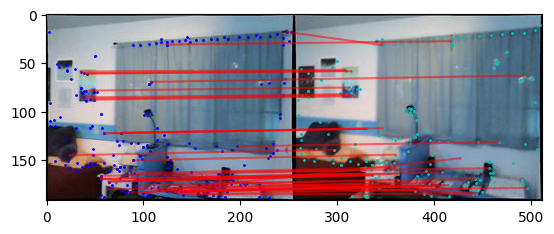

In [3]:
r = np.ones(n) / n
c = np.ones(m) / m


# M =des1.dot(des2.T)
M = distance_matrix(des1, des2)
M/=np.max(M)

P, d = compute_optimal_transport(M, r, c, lam=300, epsilon=1e-5)

fig, ax = plt.subplots(ncols=1)
ax.scatter(X1[:,0], X1[:,1], color='b',s=1)
ax.scatter(X2[:,0]+256, X2[:,1], color='c',s=1)

P_copy = np.array(P)
match_idx_x = []
match_idx_y = []

count = 0
good = []
while count < 40:
    count += 1
    max_i_idx = np.argmax(np.max(P_copy,axis=1))
    max_j_idx = np.argmax(P_copy[max_i_idx])

    match_idx_x.append(max_i_idx)
    match_idx_y.append(max_j_idx)

    P_copy[max_i_idx,:] = 0
    P_copy[:,max_j_idx] = 0

for i, j in zip(match_idx_x, match_idx_y):
    ax.plot([X1[i,0], X2[j,0]+256], [X1[i,1], X2[j,1]], color='r', alpha=0.5)

img_comb = np.hstack((img1, img2))
plt.imshow(img_comb)

SuperGlue Implementation:

In [4]:
def log_sinkhorn_iterations(Z: torch.Tensor, log_mu: torch.Tensor, log_nu: torch.Tensor, iters: int) -> torch.Tensor:
    """ Perform Sinkhorn Normalization in Log-space for stability"""
    u, v = torch.zeros_like(log_mu), torch.zeros_like(log_nu)
    for _ in range(iters):
        u = log_mu - torch.logsumexp(Z + v.unsqueeze(1), dim=2)
        v = log_nu - torch.logsumexp(Z + u.unsqueeze(2), dim=1)
    return Z + u.unsqueeze(2) + v.unsqueeze(1)


def log_optimal_transport(scores: torch.Tensor, alpha: torch.Tensor, iters: int) -> torch.Tensor:
    """ Perform Differentiable Optimal Transport in Log-space for stability"""
    b, m, n = scores.shape
    one = scores.new_tensor(1)
    ms, ns = (m*one).to(scores), (n*one).to(scores)

    bins0 = alpha.expand(b, m, 1)
    bins1 = alpha.expand(b, 1, n)
    alpha = alpha.expand(b, 1, 1)

    couplings = torch.cat([torch.cat([scores, bins0], -1),
                           torch.cat([bins1, alpha], -1)], 1)

    norm = - (ms + ns).log()
    log_mu = torch.cat([norm.expand(m), ns.log()[None] + norm])
    log_nu = torch.cat([norm.expand(n), ms.log()[None] + norm])
    log_mu, log_nu = log_mu[None].expand(b, -1), log_nu[None].expand(b, -1)

    Z = log_sinkhorn_iterations(couplings, log_mu, log_nu, iters)
    Z = Z - norm  # multiply probabilities by M+N
    return Z


def arange_like(x, dim: int):
    return x.new_ones(x.shape[dim]).cumsum(0) - 1  # traceable in 1.1

Num matches:  torch.Size([1, 128, 235]) torch.Size([1, 128, 215])
indices0:  torch.Size([1, 235]) max:  tensor(209)
indices1:  torch.Size([1, 215]) max:  tensor(232)


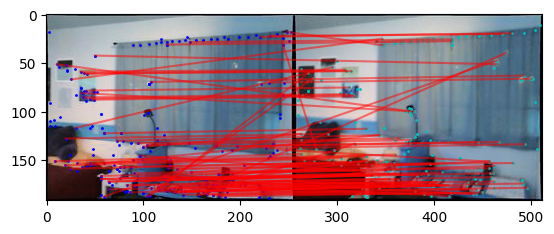

In [26]:

# Convert des1 and des2 into torch tensors

mdesc0 = torch.from_numpy(des1).unsqueeze(0).permute(0,2,1)
mdesc1 = torch.from_numpy(des2).unsqueeze(0).permute(0,2,1)

match_threshold = 0.999
bin_score = torch.tensor(0.001)
sinkhorn_iterations = 100

# Compute matching descriptor distance.
scores = torch.einsum('bdn,bdm->bnm', mdesc0, mdesc1)
scores = scores / mdesc0.shape[1]**.5

# Run the optimal transport.
scores = log_optimal_transport(
    scores, bin_score,
    iters=sinkhorn_iterations)

# Get the matches with score above "match_threshold".
max0, max1 = scores[:, :-1, :-1].max(2), scores[:, :-1, :-1].max(1)
indices0, indices1 = max0.indices, max1.indices
mutual0 = arange_like(indices0, 1)[None] == indices1.gather(1, indices0)
mutual1 = arange_like(indices1, 1)[None] == indices0.gather(1, indices1)
zero = scores.new_tensor(0)
mscores0 = torch.where(mutual0, max0.values.exp(), zero)
mscores1 = torch.where(mutual1, mscores0.gather(1, indices1), zero)
valid0 = mutual0 & (mscores0 > match_threshold)
valid1 = mutual1 & valid0.gather(1, indices1)
indices0 = torch.where(valid0, indices0, indices0.new_tensor(-1))
indices1 = torch.where(valid1, indices1, indices1.new_tensor(-1))

print("Num matches: ", mdesc0.shape, mdesc1.shape)
print("indices0: ", indices0.shape, "max: ", indices0.max())
print("indices1: ", indices1.shape, "max: ", indices1.max())
## indices0 provides a location of a match for all features in mdesc0, where the location of the nth feature in mdesc1

fig, ax = plt.subplots(ncols=1)

plt.imshow(img_comb)

ax.scatter(X1[:,0], X1[:,1], color='b',s=1)
ax.scatter(X2[:,0]+256, X2[:,1], color='c',s=1)

for idx in range(0, indices0.shape[1]):
  if indices0[0,idx] != -1:

    p0 = X1[idx]
    p1 = X2[indices0[0,idx]]
    ax.plot([p0[0], p1[0]+256], [p0[1], p1[1]], color='r', alpha=0.5)
